# Evaluate Sentinel-2 Model Deployment and Infrastructure Density Scores

## Import required libraries

In [1]:
import os
import glob

import geopandas as gpd
import pandas as pd
import numpy as np

import boto3

from matplotlib import pyplot as plt

from IPython.display import clear_output

## Inputs and parameters

In [2]:
s3_path = 'S2-RGB-macro-localization-model-deployment4/'
consolidated_score_gjson = 'S2-deployment-chip-scores-CHN-10km-nowater-2020-consolidated.geojson'
s2_grid_gjson = '../../resources/macro-loc-model-deployment4/S2-deployment-grid-CHN-10km-nowater.geojson'
LOCAL_DIR = '/scratch/'

In [3]:
calc_crs = 'EPSG:3395'

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('sfi-shared-assets')

## Outputs

In [5]:
deployment_data_path = '../../resources/macro-loc-model-deployment4/'
output_prefix = 'S2-deployment-CHN-10km-nowater-2020-'

cmt_comb_prob_scatter_png = deployment_data_path+output_prefix+'cement-comb-score-scatter.png'
cmt_comb_prob_hist_png = deployment_data_path+output_prefix+'cement-comb-score-hist.png'
cmt_knwn_comb_hist_png = deployment_data_path+output_prefix+'cement-knwn-comb-score-hist.png'

stl_comb_prob_scatter_png = deployment_data_path+output_prefix+'steel-comb-score-scatter.png'
stl_comb_prob_hist_png = deployment_data_path+output_prefix+'steel-comb-score-hist.png'
stl_knwn_comb_hist_png = deployment_data_path+output_prefix+'steel-knwn-comb-score-hist.png'

## Download consolidated deployment results and read it in

In [6]:
bucket.download_file(s3_path+consolidated_score_gjson,
                     LOCAL_DIR+consolidated_score_gjson)

In [7]:
unq_chip_gdf = gpd.read_file(LOCAL_DIR+consolidated_score_gjson)

In [8]:
chp_cnt = len(unq_chip_gdf)
print('Number of chips: ', str(chp_cnt))

Number of chips:  415036


## Evaluate options for S2 and Infrastructure density model fusion

In [9]:
qbins = [0, 0.25, 0.5, 0.75, 1]

### Cement

In [10]:
unq_chip_gdf['cmt_pred_grp'] = pd.qcut(unq_chip_gdf.tile_inds_cmt_pred_wavg, q=qbins)

In [11]:
cmt_prob_knwn = unq_chip_gdf[~unq_chip_gdf.cmtv4p1_uid.isnull()]

#### Scatter Plot

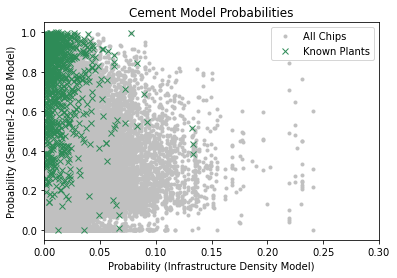

In [12]:
fig, ax = plt.subplots(1)
plt.plot(unq_chip_gdf.tile_inds_cmt_pred_wavg, unq_chip_gdf.tile_cmt_prob, 
         color='silver', marker='.', linestyle='', label='All Chips')
plt.plot(cmt_prob_knwn.tile_inds_cmt_pred_wavg, cmt_prob_knwn.tile_cmt_prob, 
         color='seagreen', marker='x', linestyle='', label='Known Plants')
plt.xlim([0,0.3])
plt.xlabel('Probability (Infrastructure Density Model)')
plt.ylabel('Probability (Sentinel-2 RGB Model)')
plt.legend()
plt.title('Cement Model Probabilities')
fig.savefig(cmt_comb_prob_scatter_png)

#### Divide chips into quartiles based on infrastructure density prediction

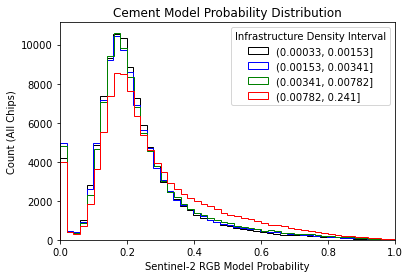

In [13]:
comp_grp_scores = unq_chip_gdf.groupby('cmt_pred_grp')
fig, ax = plt.subplots(1)
ecol = ['k', 'b', 'g', 'r']
labs = [str(f) for f in list(comp_grp_scores.groups.keys())]
i = 0
for group in comp_grp_scores:
    plt.hist(group[1].tile_cmt_prob, bins=50,
                 color=ecol[i], edgecolor=ecol[i],
                 label=labs[i], histtype='step')
    i = i+1
    
plt.legend(title='Infrastructure Density Interval')
plt.xlabel('Sentinel-2 RGB Model Probability')
plt.ylabel('Count (All Chips)')
plt.title('Cement Model Probability Distribution')
plt.xlim([0,1])
fig.savefig(cmt_comb_prob_hist_png)

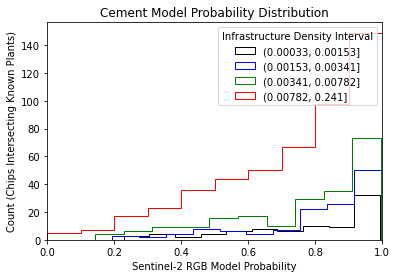

In [14]:
cmt_prob_knwn_grps = cmt_prob_knwn.groupby('cmt_pred_grp')
fig, ax = plt.subplots(1)
ecol = ['k', 'b', 'g', 'r']
labs = [str(f) for f in list(cmt_prob_knwn_grps.groups.keys())]
i = 0
for group in cmt_prob_knwn_grps:
    plt.hist(group[1].tile_cmt_prob, bins=10,
                 color=ecol[i], edgecolor=ecol[i],
                 label=labs[i], histtype='step')
    i = i+1
    
plt.legend(title='Infrastructure Density Interval')
plt.xlabel('Sentinel-2 RGB Model Probability')
plt.ylabel('Count (Chips Intersecting Known Plants)')
plt.title('Cement Model Probability Distribution')
plt.xlim([0,1])
fig.savefig(cmt_knwn_comb_hist_png)

In [15]:
print('Number of Cement Plants per Quantile:')
print(cmt_prob_knwn['cmt_pred_grp'].value_counts())

Number of Cement Plants per Quantile:
(0.00782, 0.241]      496
(0.00341, 0.00782]    208
(0.00153, 0.00341]    132
(0.00033, 0.00153]     84
Name: cmt_pred_grp, dtype: int64


Text(0, 0.5, 'Sentinel-2 RGB Model Probability')

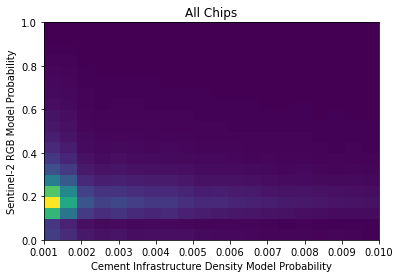

In [38]:
fig, ax = plt.subplots(1)
h, xedge, yedge, im = plt.hist2d(unq_chip_gdf.tile_inds_cmt_pred_wavg, unq_chip_gdf.tile_cmt_prob, 
                                 bins=[20, 20],
                                 range=[[0.001, 0.01], [0, 1]])
plt.title('All Chips')
plt.xlabel('Cement Infrastructure Density Model Probability')
plt.ylabel('Sentinel-2 RGB Model Probability')

Text(0, 0.5, 'Sentinel-2 RGB Model Probability')

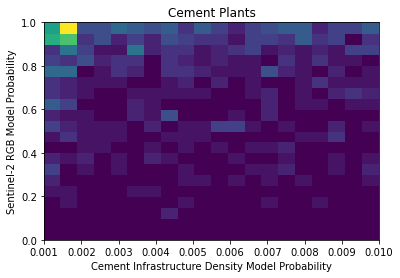

In [39]:
fig, ax = plt.subplots(1)
h, xedge, yedge, im = plt.hist2d(cmt_prob_knwn.tile_inds_cmt_pred_wavg, cmt_prob_knwn.tile_cmt_prob, 
                                 bins=[20, 20],
                                 range=[[0.001, 0.01], [0, 1]])
plt.title('Cement Plants')
plt.xlabel('Cement Infrastructure Density Model Probability')
plt.ylabel('Sentinel-2 RGB Model Probability')

### Steel

In [16]:
unq_chip_gdf['stl_pred_grp'] = pd.qcut(unq_chip_gdf.tile_inds_stl_pred_wavg, q=qbins)

In [17]:
stl_prob_knwn = unq_chip_gdf[~unq_chip_gdf.stlv4p1_uid.isnull()]

#### Scatter Plot

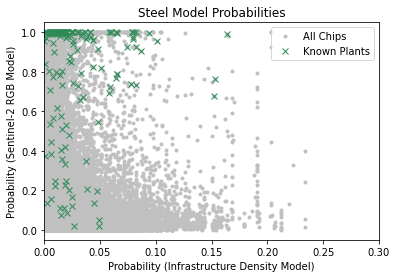

In [18]:
fig, ax = plt.subplots(1)
plt.plot(unq_chip_gdf.tile_inds_stl_pred_wavg, unq_chip_gdf.tile_stl_prob, 
         color='silver', marker='.', linestyle='', label='All Chips')
plt.plot(stl_prob_knwn.tile_inds_stl_pred_wavg, stl_prob_knwn.tile_stl_prob, 
         color='seagreen', marker='x', linestyle='', label='Known Plants')
plt.xlim([0,0.3])
plt.xlabel('Probability (Infrastructure Density Model)')
plt.ylabel('Probability (Sentinel-2 RGB Model)')
plt.legend()
plt.title('Steel Model Probabilities')
fig.savefig(stl_comb_prob_scatter_png)

#### Divide chips into quartiles based on infrastructure density prediction

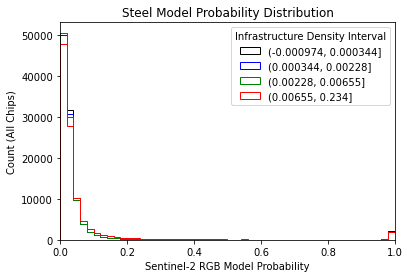

In [19]:
comp_grp_scores = unq_chip_gdf.groupby('stl_pred_grp')
fig, ax = plt.subplots(1)
ecol = ['k', 'b', 'g', 'r']
labs = [str(f) for f in list(comp_grp_scores.groups.keys())]
i = 0
for group in comp_grp_scores:
    plt.hist(group[1].tile_stl_prob, bins=50,
                 color=ecol[i], edgecolor=ecol[i],
                 label=labs[i], histtype='step')
    i = i+1
    
plt.legend(title='Infrastructure Density Interval')
plt.xlabel('Sentinel-2 RGB Model Probability')
plt.ylabel('Count (All Chips)')
plt.title('Steel Model Probability Distribution')
plt.xlim([0,1])
fig.savefig(stl_comb_prob_hist_png)

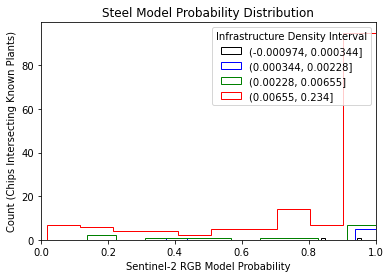

In [20]:
stl_prob_knwn_grps = stl_prob_knwn.groupby('stl_pred_grp')
fig, ax = plt.subplots(1)
ecol = ['k', 'b', 'g', 'r']
labs = [str(f) for f in list(stl_prob_knwn_grps.groups.keys())]
i = 0
for group in stl_prob_knwn_grps:
    plt.hist(group[1].tile_stl_prob, bins=10,
                 color=ecol[i], edgecolor=ecol[i],
                 label=labs[i], histtype='step')
    i = i+1
    
plt.legend(title='Infrastructure Density Interval')
plt.xlabel('Sentinel-2 RGB Model Probability')
plt.ylabel('Count (Chips Intersecting Known Plants)')
plt.title('Steel Model Probability Distribution')
plt.xlim([0,1])
fig.savefig(stl_knwn_comb_hist_png)

In [21]:
print('Number of Steel Plants per Quantile:')
print(stl_prob_knwn['stl_pred_grp'].value_counts())

Number of Steel Plants per Quantile:
(0.00655, 0.234]         149
(0.00228, 0.00655]        14
(0.000344, 0.00228]        6
(-0.000974, 0.000344]      2
Name: stl_pred_grp, dtype: int64


Text(0, 0.5, 'Sentinel-2 RGB Model Probability')

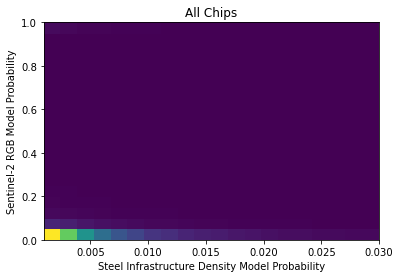

In [44]:
fig, ax = plt.subplots(1)
h, xedge, yedge, im = plt.hist2d(unq_chip_gdf.tile_inds_stl_pred_wavg, unq_chip_gdf.tile_stl_prob, 
                                 bins=[20, 20],
                                 range=[[0.001, 0.03], [0, 1]])
plt.title('All Chips')
plt.xlabel('Steel Infrastructure Density Model Probability')
plt.ylabel('Sentinel-2 RGB Model Probability')

Text(0, 0.5, 'Sentinel-2 RGB Model Probability')

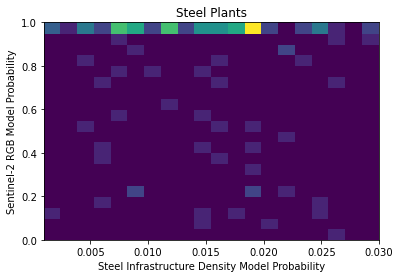

In [43]:
fig, ax = plt.subplots(1)
h, xedge, yedge, im = plt.hist2d(stl_prob_knwn.tile_inds_stl_pred_wavg, stl_prob_knwn.tile_stl_prob, 
                                 bins=[20, 20],
                                 range=[[0.001, 0.03], [0, 1]])
plt.title('Steel Plants')
plt.xlabel('Steel Infrastructure Density Model Probability')
plt.ylabel('Sentinel-2 RGB Model Probability')